# Build a language model with ULMFiT
In this section, we will build a language model using ULMFiT from Fastai. The benefits using this library is that 1) it does data preprocessing behind the scence with a few line of codes. 2) the language model has pretrained weights, which is a step up from word embeddings, a technique converting tokens into floats that is comonmly used in NLP.

## Select relvent columns
For the sentiment analysis, we will only be using a label column and a text column. In this case, we will need to select 'airline_sentiment' and 'text' columns.

In [4]:
import pandas as pd
import fastai
from fastai import *
from fastai.text.all import *

In [21]:
# create a new dataframe with relevent columns
df = pd.read_csv("Tweets.csv")
df = tweets[['airline_sentiment','text']]
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Tweets pre-processing
Here we will create two data bunches using the TextLMDataBunch and TextClassDataBunch, one for the language model and one for the classifer which is shown in the next section

In [29]:
# split dataset to training and testing with a 80-20 ratio
train = df[:int(len(df)*0.8)]
valid = df[:int(len(df)*0.2)]

This part does the data pre-processing behind the scence, according to the fastai documentation. Note: depending on the fastai version, another way to load text is to use TextDataLoaders.from_df()

In [23]:
# create two data bunches using from_df()
data_lm = TextLMDataBunch.from_df(filepath, train, valid)
data_clas = TextClasDataBunch.from_df(filepath, train, valid)

In [24]:
# save the result for time-saving purpose
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

Here is to create a 'tmp' directory where all the computed stuff will be stored.

In [25]:
data_lm = load_data(filepath, 'data_lm_export.pkl')
data_clas = load_data(filepath, 'data_clas_export.pkl', bs=16)

## Fine-tuning a language model
Here the language_model_learner will create a language model by passing on three arguments: the dataset, the AWD-LSTM pretrained model and the dropout percentage. 

According to the fast.ai documentation, the process includes: find a optimal learner rate, pass the rate on to train the top layer, unfreeze all the layers, and then start by finding the optimal rate again.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


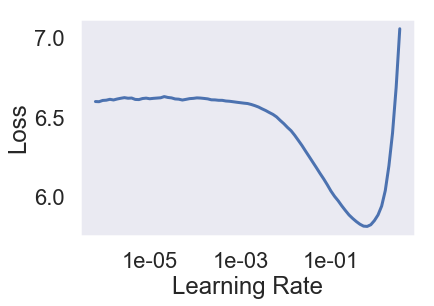

In [26]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

# find learning rate
learn.lr_find() 

# plot the learning rate graph to find the optimal rate
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.852510,4.128626,0.267174,06:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


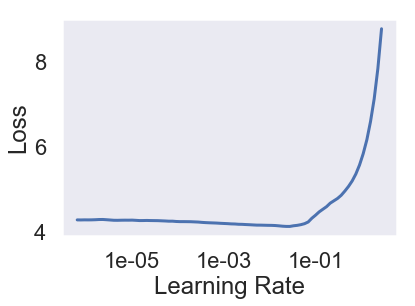

In [28]:
# unfreeze the model for fine-tuning
learn.unfreeze() 

learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.104807,3.912250,0.292550,09:01
1,3.946181,3.678009,0.319824,09:13
2,3.776087,3.444590,0.347196,09:33
3,3.592677,3.188674,0.383329,08:49
4,3.386291,2.944526,0.421554,09:03
5,3.173692,2.722960,0.459305,10:37
6,2.990993,2.546988,0.492704,10:17
7,2.829826,2.420938,0.515555,09:22
8,2.726323,2.368799,0.524888,09:07
9,2.673135,2.360092,0.526576,1:22:01


To evaluate the language model, we can use learn.predict. We set the number of works to be predicted to 30 and the raw text as 'my flight'. The entire prediction does not really make sense but the first part seems logical-- my flight was no more than 2 hour waiting.

In [33]:
# use learn.predict to evaluate the language model
learn.predict("My flight", n_words=30)

'My flight was no more than 2 hour waiting for a $ 75 fee for reference number as opposed to US Airways credit . # unitedairlines xxbos @usairways i just'

In [34]:
# save the encoder to be used for the classifer model
learn.save_encoder('ft_enc')

# Build an AWD-LSTM classifier
In this section, we will use the data_clas to build our classifier using the encoder saved above. The steps of building an AWD-LSTM is the same as building the language model above.

Below, we noticed the 'xx'added before some tokens. These are some special tokens from Fast.ai

In [36]:
# create the classifer model
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# load the encoder above
learn.load_encoder('ft_enc')

data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj corp. xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and recheck on xxup xxunk ?",neutral
"xxbos @southwestair i had to travel to xxmaj savannah , xxup ga , once again , on an airline i do n't "" xxmaj luv "" . xxmaj when r u going to fly me to xxmaj savannah ? xxmaj pl xxrep 4 e ase xxrep 4 !",neutral
"xxbos @southwestair xxmaj loved one 's flight xxup atl to xxup ind xxmaj cancelled xxmaj flightled due to "" ice in xxmaj indy "" . xxmaj sitting here in xxmaj indy , it is xxunk dry . xxmaj tomorrow 4 - 6 "" of snow .",negative


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


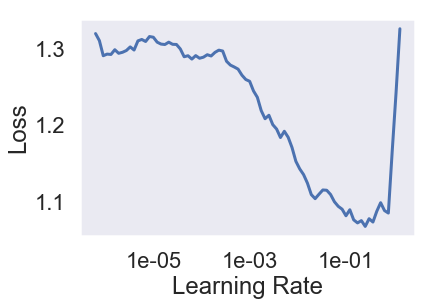

In [37]:
# find and plot learning rate
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.676943,0.503892,0.796086,05:44


Here instead of unfreeze all the layers, we unfrezz one layer at a time, which provides better results.

In [39]:
# unfreeze one layer group and train another epoch
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))


epoch,train_loss,valid_loss,accuracy,time
0,0.624320,0.438233,0.816341,09:08


epoch,train_loss,valid_loss,accuracy,time
0,0.583865,0.399523,0.849296,18:24


In [40]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.495593,0.365974,0.857192,24:45


Here we use learn.predict() to evaluate the classfier by providing several texts. The results show the predicted the sentiments.

In [41]:
learn.predict("It is raining outside")

(Category neutral, tensor(1), tensor([0.3560, 0.5415, 0.1025]))

In [44]:
learn.predict("I am late for the airport ")

(Category negative, tensor(0), tensor([0.4811, 0.4315, 0.0874]))

In [43]:
learn.predict("My flight is amazing")

(Category positive, tensor(2), tensor([0.0573, 0.0236, 0.9191]))